In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
import random
import matplotlib.pyplot as plt
import os
from tqdm import tqdm


%matplotlib inline

# Set Seed
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

In [8]:
transform = transforms.ToTensor()

# Download MNIST
train_dataset = datasets.MNIST(
    root="../data", train=True, download=True, transform=transform
)
test_dataset = datasets.MNIST(
    root="../data", train=False, download=True, transform=transform
)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)



100%|██████████| 9.91M/9.91M [00:04<00:00, 2.24MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 317kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 2.43MB/s]
100%|██████████| 4.54k/4.54k [00:00<?, ?B/s]


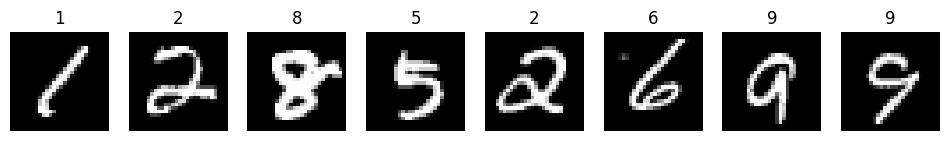

In [ ]:
# Test the download
images, labels = next(iter(train_loader))
fig, axes = plt.subplots(1, 8, figsize=(12, 2))
for i, ax in enumerate(axes):
    ax.imshow(images[i].squeeze(), cmap="gray")
    ax.set_title(str(labels[i].item()))
    ax.axis("off")
plt.show()


In [ ]:
class VAE(nn.Module):
    def __init__(self, input_dim=28*28, hidden_dim=400, latent_dim=20):
        super().__init__()
        # Encoder
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

        # Decoder
        self.fc3 = nn.Linear(latent_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, input_dim)

    def encode(self, x):
        # x shape: [B, 1, 28, 28] or [B, 784]
        if x.dim() == 4:
            x = x.view(x.size(0), -1)
        h = F.relu(self.fc1(x))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + std * eps

    def decode(self, z):
        h = F.relu(self.fc3(z))
        x_hat = torch.sigmoid(self.fc4(h))  # outputs in (0,1) for BCE
        return x_hat

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_hat = self.decode(z)
        return x_hat, mu, logvar

In [11]:
def vae_loss(recon_x, x, mu, logvar, reduction='sum'):
    # recon_x and x should be shaped [B, 784] and values in [0,1]
    # Reconstruction loss: BCE per pixel
    # Use 'sum' reduction to match KL which is summed per sample
    bce = F.binary_cross_entropy(recon_x, x.view(-1, 28*28), reduction=reduction)
    # KL divergence (analytic)
    # Sum over latent dims, then sum over batch if reduction='sum'
    kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return bce + kl, bce, kl


In [33]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VAE(latent_dim=20).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 50
for epoch in range(1, num_epochs+1):
    model.train()
    train_loss = 0.0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)  # shape [B,1,28,28]
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss, bce, kl = vae_loss(recon_batch, data, mu, logvar, reduction='sum')
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    avg_loss = train_loss / len(train_loader.dataset)
    print(f"Epoch {epoch}, Avg loss per datapoint: {avg_loss:.4f}")


KeyboardInterrupt: 

In [31]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Recreate the model with the *same* hyperparameters
loaded_model = VAE(latent_dim=20).to(device)
loaded_optimizer = torch.optim.Adam(loaded_model.parameters(), lr=1e-3)  # same optimizer as before

checkpoint = torch.load("vae_lat20_trained.pt", map_location=device)
loaded_model.load_state_dict(checkpoint['model_state_dict'])
loaded_optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

model = loaded_model
optimizer = loaded_optimizer
print(f"✅ Loaded model from epoch {checkpoint['epoch']}")


✅ Loaded model from epoch 150


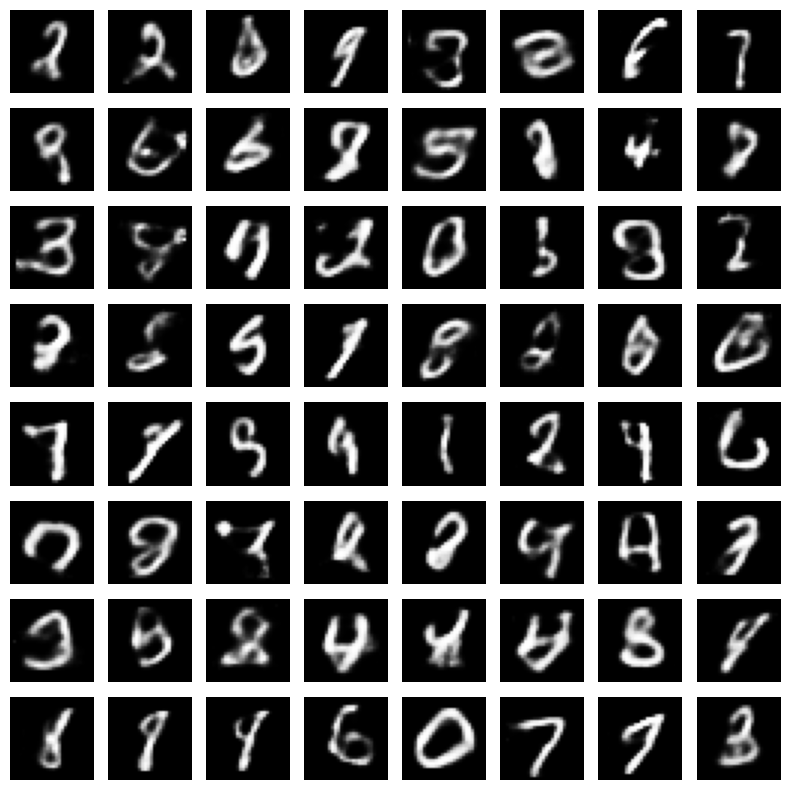

In [32]:
with torch.no_grad():
    z = torch.randn(64, 20).to(device)
    samples = model.decode(z)  # shape [64, 784], values in (0,1)
    samples = samples.view(-1, 1, 28, 28).cpu()


fig, axes = plt.subplots(8, 8, figsize=(8, 8))
for i, ax in enumerate(axes.flat):
    ax.imshow(samples[i].squeeze(), cmap="gray")
    ax.axis("off")
plt.tight_layout()
plt.show()
